# Reinforce Algorthim Training

This notebook implements the REINFORCE (Monte Carlo Policy Gradient) algorithm to train an agent for the fire-rescue mission environment.

In [1]:
# %% Cell 1: Imports and Setup
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import deque
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from environment.custom_env import FireRescueEnv

# Set random seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories
os.makedirs("../models/reinforce", exist_ok=True)
os.makedirs("../models/reinforce/best_model", exist_ok=True)

Using device: cpu


In [2]:
# %% Cell 2: Policy Network Architecture
class PolicyNetwork(nn.Module):
    """Neural network for policy approximation in REINFORCE."""
    
    def __init__(self, state_dim, action_dim, hidden_dims=[128, 64]):
        super(PolicyNetwork, self).__init__()
        
        layers = []
        prev_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, action_dim))
        layers.append(nn.Softmax(dim=-1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.network(state)

In [3]:
# %% Cell 3: REINFORCE Agent Implementation
class REINFORCEAgent:
    """REINFORCE algorithm implementation."""
    
    def __init__(self, state_dim, action_dim, learning_rate=0.001, 
                 gamma=0.99, hidden_dims=[128, 64], entropy_coef=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        
        self.policy = PolicyNetwork(state_dim, action_dim, hidden_dims).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        
        self.saved_log_probs = []
        self.rewards = []
        self.entropies = []
    
    def select_action(self, state, training=True):
        """Select action using current policy."""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy(state)
        
        if training:
            m = Categorical(probs)
            action = m.sample()
            self.saved_log_probs.append(m.log_prob(action))
            self.entropies.append(m.entropy())
            return action.item()
        else:
            return torch.argmax(probs).item()
    
    def store_reward(self, reward):
        """Store reward for current step."""
        self.rewards.append(reward)
    
    def update(self):
        """Update policy using REINFORCE algorithm."""
        if len(self.rewards) == 0:
            return 0.0
        
        # Calculate discounted returns
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        
        # Normalize returns
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Calculate policy loss
        policy_loss = []
        for log_prob, G, entropy in zip(self.saved_log_probs, returns, self.entropies):
            policy_loss.append(-log_prob * G - self.entropy_coef * entropy)
        
        # Optimize
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.optimizer.step()
        
        # Clear episode data
        loss_value = loss.item()
        self.saved_log_probs = []
        self.rewards = []
        self.entropies = []
        
        return loss_value
    
    def save(self, path):
        """Save model."""
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)
    
    def load(self, path):
        """Load model."""
        checkpoint = torch.load(path, map_location=device)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [4]:
# %% Cell 4: Training Function
def train_reinforce(env, agent, num_episodes=2000, save_path=None, 
                   config_name="default", verbose_freq=100):
    """Train REINFORCE agent."""
    
    episode_rewards = []
    episode_lengths = []
    success_rate_history = []
    loss_history = []
    recent_rewards = deque(maxlen=100)
    recent_successes = deque(maxlen=100)
    
    best_avg_reward = -np.inf
    
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        
        # Collect episode
        while not done:
            action = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            agent.store_reward(reward)
            episode_reward += reward
            episode_length += 1
            state = next_state
        
        # Update policy
        loss = agent.update()
        
        # Track metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        recent_rewards.append(episode_reward)
        recent_successes.append(1 if info.get('success', False) else 0)
        loss_history.append(loss)
        
        avg_reward = np.mean(recent_rewards)
        success_rate = np.mean(recent_successes)
        success_rate_history.append(success_rate)
        
        # Save best model
        if avg_reward > best_avg_reward and episode > 100:
            best_avg_reward = avg_reward
            if save_path:
                agent.save(save_path)
        
        # Logging
        if episode % verbose_freq == 0:
            print(f"Episode {episode}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Success Rate: {success_rate:.2%} | "
                  f"Loss: {loss:.4f}")
    
    # Save final metrics
    metrics = {
        'config_name': config_name,
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'success_rate_history': success_rate_history,
        'loss_history': loss_history,
        'best_avg_reward': best_avg_reward,
        'final_success_rate': success_rate_history[-1] if success_rate_history else 0
    }
    
    return metrics

In [5]:
# %% Cell 5: Hyperparameter Configurations
HYPERPARAMETER_CONFIGS = [
    {
        'name': 'config_1_baseline',
        'learning_rate': 0.001,
        'gamma': 0.99,
        'hidden_dims': [128, 64],
        'entropy_coef': 0.01,
        'num_episodes': 2000
    },
    {
        'name': 'config_2_high_lr',
        'learning_rate': 0.003,
        'gamma': 0.99,
        'hidden_dims': [128, 64],
        'entropy_coef': 0.01,
        'num_episodes': 2000
    },
    {
        'name': 'config_3_low_lr',
        'learning_rate': 0.0005,
        'gamma': 0.99,
        'hidden_dims': [128, 64],
        'entropy_coef': 0.01,
        'num_episodes': 2000
    },
    {
        'name': 'config_4_high_gamma',
        'learning_rate': 0.001,
        'gamma': 0.995,
        'hidden_dims': [128, 64],
        'entropy_coef': 0.01,
        'num_episodes': 2000
    },
    {
        'name': 'config_5_low_gamma',
        'learning_rate': 0.001,
        'gamma': 0.95,
        'hidden_dims': [128, 64],
        'entropy_coef': 0.01,
        'num_episodes': 2000
    },
    {
        'name': 'config_6_deep_network',
        'learning_rate': 0.001,
        'gamma': 0.99,
        'hidden_dims': [256, 128, 64],
        'entropy_coef': 0.01,
        'num_episodes': 2000
    },
    {
        'name': 'config_7_shallow_network',
        'learning_rate': 0.001,
        'gamma': 0.99,
        'hidden_dims': [64],
        'entropy_coef': 0.01,
        'num_episodes': 2000
    },
    {
        'name': 'config_8_high_entropy',
        'learning_rate': 0.001,
        'gamma': 0.99,
        'hidden_dims': [128, 64],
        'entropy_coef': 0.05,
        'num_episodes': 2000
    },
    {
        'name': 'config_9_no_entropy',
        'learning_rate': 0.001,
        'gamma': 0.99,
        'hidden_dims': [128, 64],
        'entropy_coef': 0.0,
        'num_episodes': 2000
    },
    {
        'name': 'config_10_optimal',
        'learning_rate': 0.002,
        'gamma': 0.99,
        'hidden_dims': [256, 128],
        'entropy_coef': 0.02,
        'num_episodes': 2000
    }
]

print(f"Total configurations to train: {len(HYPERPARAMETER_CONFIGS)}")

Total configurations to train: 10


In [6]:
# %% Cell 6: Train All Configurations
all_results = []

for i, config in enumerate(HYPERPARAMETER_CONFIGS, 1):
    print(f"\n{'='*70}")
    print(f"Training Configuration {i}/{len(HYPERPARAMETER_CONFIGS)}: {config['name']}")
    print(f"{'='*70}")
    print(f"Parameters: LR={config['learning_rate']}, γ={config['gamma']}, "
          f"Hidden={config['hidden_dims']}, Entropy={config['entropy_coef']}")
    
    # Create environment and agent
    env = FireRescueEnv(grid_size=10, max_time=120)
    agent = REINFORCEAgent(
        state_dim=env.obs_dim,
        action_dim=env.action_space.n,
        learning_rate=config['learning_rate'],
        gamma=config['gamma'],
        hidden_dims=config['hidden_dims'],
        entropy_coef=config['entropy_coef']
    )
    
    # Train
    save_path = f"../models/reinforce/{config['name']}.pth"
    metrics = train_reinforce(
        env, agent, 
        num_episodes=config['num_episodes'],
        save_path=save_path,
        config_name=config['name'],
        verbose_freq=200
    )
    
    # Add config to metrics
    metrics['config'] = config
    all_results.append(metrics)
    
    print(f"✓ Best Avg Reward: {metrics['best_avg_reward']:.2f}")
    print(f"✓ Final Success Rate: {metrics['final_success_rate']:.2%}")
    
    env.close()

# Save all results
with open('../models/reinforce/all_results.json', 'w') as f:
    json.dump([{k: v for k, v in r.items() if k != 'config'} for r in all_results], f, indent=2)

print("\n" + "="*70)
print("ALL TRAINING COMPLETED!")
print("="*70)


Training Configuration 1/10: config_1_baseline
Parameters: LR=0.001, γ=0.99, Hidden=[128, 64], Entropy=0.01
Episode 200/2000 | Avg Reward: 12.60 | Success Rate: 0.00% | Loss: -16.1557
Episode 400/2000 | Avg Reward: 16.79 | Success Rate: 0.00% | Loss: -7.2193
Episode 600/2000 | Avg Reward: 23.45 | Success Rate: 0.00% | Loss: -5.2306
Episode 800/2000 | Avg Reward: 23.56 | Success Rate: 0.00% | Loss: -5.5762
Episode 1000/2000 | Avg Reward: 28.47 | Success Rate: 0.00% | Loss: -4.3569
Episode 1200/2000 | Avg Reward: 31.24 | Success Rate: 0.00% | Loss: -25.8616
Episode 1400/2000 | Avg Reward: 29.28 | Success Rate: 0.00% | Loss: -14.7766
Episode 1600/2000 | Avg Reward: 32.08 | Success Rate: 0.00% | Loss: -12.6069
Episode 1800/2000 | Avg Reward: 35.79 | Success Rate: 0.00% | Loss: -21.2099
Episode 2000/2000 | Avg Reward: 31.11 | Success Rate: 0.00% | Loss: -15.2414
✓ Best Avg Reward: 40.11
✓ Final Success Rate: 0.00%

Training Configuration 2/10: config_2_high_lr
Parameters: LR=0.003, γ=0.99,

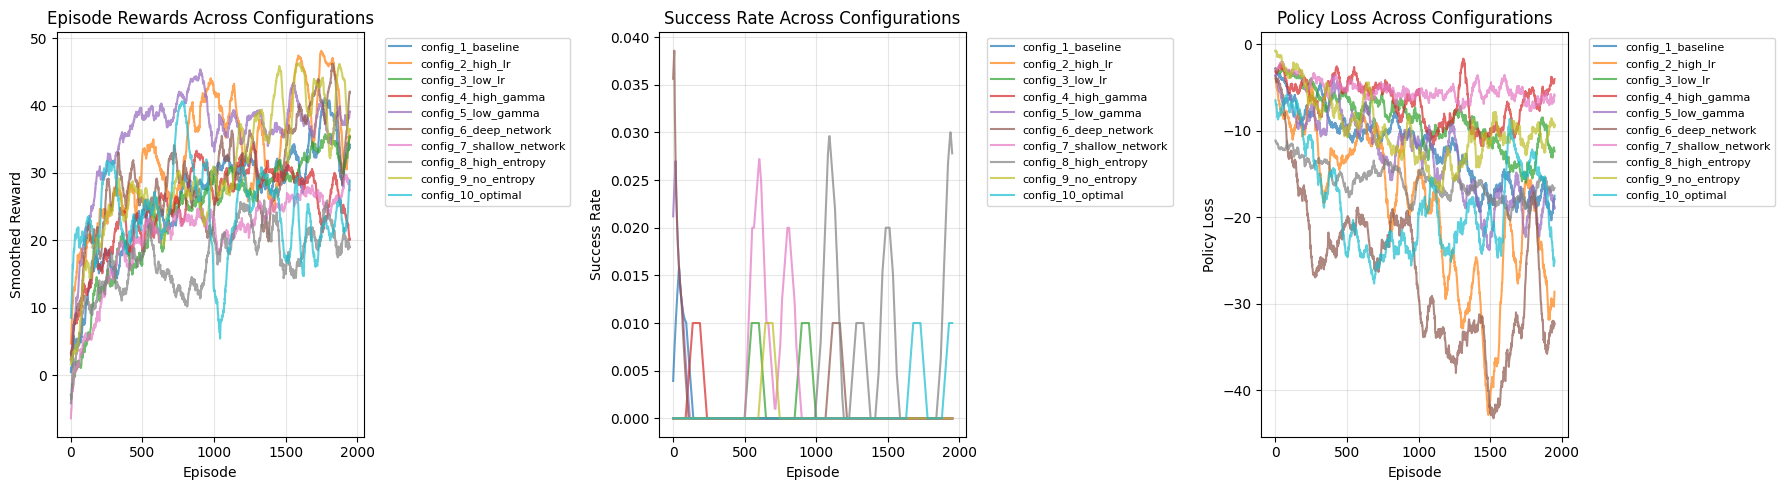

In [7]:
# %% Cell 7: Evaluation - Training Process Comparison
def plot_training_comparison(results):
    """Plot comparison of all training runs."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Episode Rewards
    ax = axes[0]
    for result in results:
        rewards = result['episode_rewards']
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        ax.plot(smoothed, label=result['config_name'], alpha=0.7)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Smoothed Reward')
    ax.set_title('Episode Rewards Across Configurations')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Success Rate
    ax = axes[1]
    for result in results:
        success_rates = result['success_rate_history']
        smoothed = np.convolve(success_rates, np.ones(50)/50, mode='valid')
        ax.plot(smoothed, label=result['config_name'], alpha=0.7)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate Across Configurations')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Loss
    ax = axes[2]
    for result in results:
        loss = result['loss_history']
        smoothed = np.convolve(loss, np.ones(50)/50, mode='valid')
        ax.plot(smoothed, label=result['config_name'], alpha=0.7)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Policy Loss')
    ax.set_title('Policy Loss Across Configurations')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../models/reinforce/training_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_comparison(all_results)

In [8]:
# %% Cell 8: Identify and Save Best Model
# Find best configuration
best_result = max(all_results, key=lambda x: x['best_avg_reward'])
best_config_name = best_result['config_name']

print(f"\n{'='*70}")
print(f"BEST CONFIGURATION: {best_config_name}")
print(f"{'='*70}")
print(f"Best Average Reward: {best_result['best_avg_reward']:.2f}")
print(f"Final Success Rate: {best_result['final_success_rate']:.2%}")
print(f"\nHyperparameters:")
for key, value in best_result['config'].items():
    if key != 'name':
        print(f"  {key}: {value}")

# Copy best model to best_model folder
import shutil
best_model_src = f"../models/reinforce/{best_config_name}.pth"
best_model_dst = "../models/reinforce/best_model/best_reinforce.pth"
shutil.copy(best_model_src, best_model_dst)

# Save best config
with open('../models/reinforce/best_model/config.json', 'w') as f:
    json.dump(best_result['config'], f, indent=2)

print(f"\n✓ Best model saved to: {best_model_dst}")


BEST CONFIGURATION: config_2_high_lr
Best Average Reward: 47.03
Final Success Rate: 0.00%

Hyperparameters:
  learning_rate: 0.003
  gamma: 0.99
  hidden_dims: [128, 64]
  entropy_coef: 0.01
  num_episodes: 2000

✓ Best model saved to: ../models/reinforce/best_model/best_reinforce.pth


In [9]:
# %% Cell 9: Evaluation Cell 2 - Best Model Performance
def evaluate_best_model(model_path, config, num_episodes=100):
    """Evaluate the best model."""
    
    env = FireRescueEnv(grid_size=10, max_time=120)
    agent = REINFORCEAgent(
        state_dim=env.obs_dim,
        action_dim=env.action_space.n,
        learning_rate=config['learning_rate'],
        gamma=config['gamma'],
        hidden_dims=config['hidden_dims'],
        entropy_coef=config['entropy_coef']
    )
    agent.load(model_path)
    
    episode_rewards = []
    episode_lengths = []
    successes = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        
        while not done:
            action = agent.select_action(state, training=False)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_length += 1
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        successes.append(1 if info.get('success', False) else 0)
    
    env.close()
    
    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'mean_length': np.mean(episode_lengths),
        'std_length': np.std(episode_lengths),
        'success_rate': np.mean(successes),
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths
    }

# Evaluate best model
eval_results = evaluate_best_model(
    best_model_dst, 
    best_result['config'],
    num_episodes=100
)

print(f"\n{'='*70}")
print("BEST MODEL EVALUATION (100 Episodes)")
print(f"{'='*70}")
print(f"Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
print(f"Mean Episode Length: {eval_results['mean_length']:.1f} ± {eval_results['std_length']:.1f}")
print(f"Success Rate: {eval_results['success_rate']:.2%}")


BEST MODEL EVALUATION (100 Episodes)
Mean Reward: 48.96 ± 1.20
Mean Episode Length: 120.0 ± 0.0
Success Rate: 0.00%


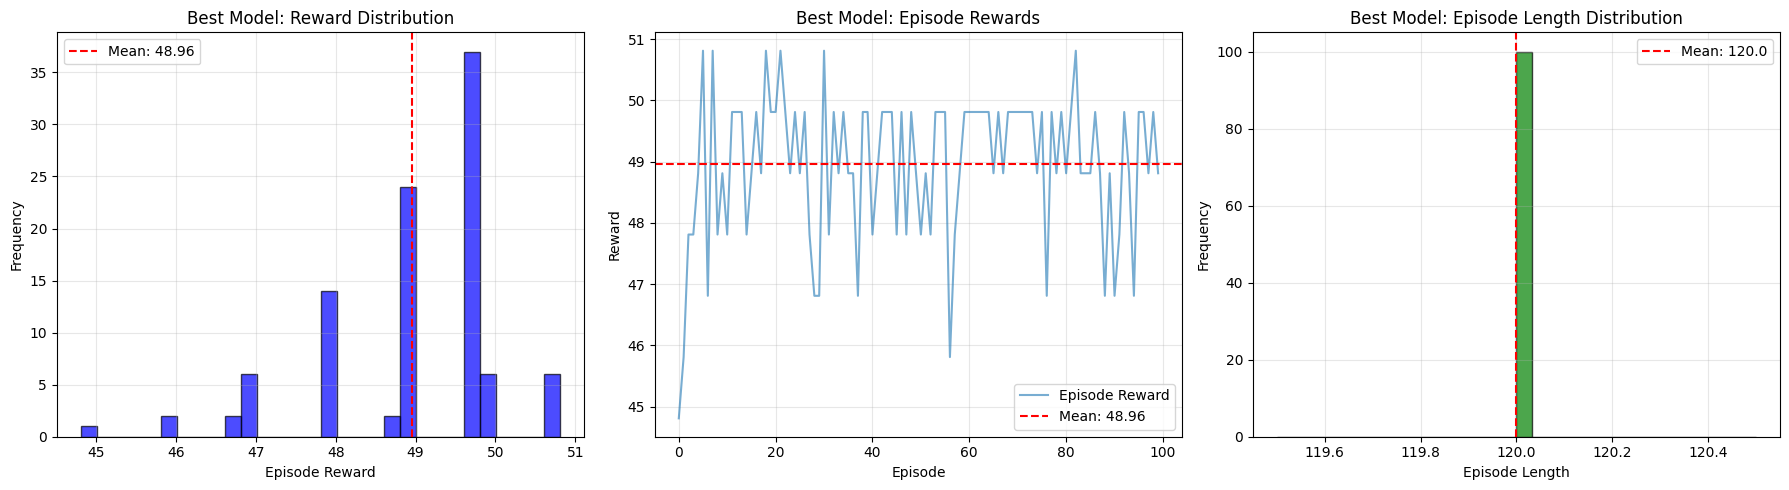


✓ All plots saved successfully!
✓ Training complete! Check '../models/reinforce/' for all saved models.


In [10]:
# %% Cell 10: Best Model Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Reward Distribution
ax = axes[0]
ax.hist(eval_results['episode_rewards'], bins=30, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(eval_results['mean_reward'], color='red', linestyle='--', 
           label=f"Mean: {eval_results['mean_reward']:.2f}")
ax.set_xlabel('Episode Reward')
ax.set_ylabel('Frequency')
ax.set_title('Best Model: Reward Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Episode Rewards Over Time
ax = axes[1]
ax.plot(eval_results['episode_rewards'], alpha=0.6, label='Episode Reward')
ax.axhline(eval_results['mean_reward'], color='red', linestyle='--', 
           label=f"Mean: {eval_results['mean_reward']:.2f}")
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Best Model: Episode Rewards')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Episode Length Distribution
ax = axes[2]
ax.hist(eval_results['episode_lengths'], bins=30, alpha=0.7, color='green', edgecolor='black')
ax.axvline(eval_results['mean_length'], color='red', linestyle='--',
           label=f"Mean: {eval_results['mean_length']:.1f}")
ax.set_xlabel('Episode Length')
ax.set_ylabel('Frequency')
ax.set_title('Best Model: Episode Length Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/reinforce/best_model/evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ All plots saved successfully!")
print("✓ Training complete! Check '../models/reinforce/' for all saved models.")